In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from interval import interval
import random
import statistics
import numpy as np
import time
import seaborn as sns
from scipy.stats import truncnorm

In [2]:
# The input files follow the "Taillard" format
def read_instance(filename):
    with open(filename) as f:
        lines = f.readlines()

    first_line = lines[0].split()
    # Number of jobs
    nb_jobs = int(first_line[0])
    # Number of machines
    nb_machines = int(first_line[1])

    # Processing times for each job on each machine (given in the processing order)
    processing_times_in_processing_order = [[int(lines[i].split()[j]) for j in range(nb_machines)] for i in
                                            range(1, 1 + nb_jobs)]

    # Processing order of machines for each job
    machine_order = [[int(lines[i].split()[j]) - 1 for j in range(nb_machines)] for i in
                     range(1 + nb_jobs, 1 + 2 * nb_jobs)]

    # Reorder processing times: processing_time[j][m] is the processing time of the
    # activity of job j that is processed on machine m
    processing_time = [[processing_times_in_processing_order[j][machine_order[j].index(m)] for m in range(nb_machines)]
                       for j in range(nb_jobs)]

    # Trivial upper bound for the start times of the activities
    max_start = sum(sum(processing_time[j]) for j in range(nb_jobs))

    return (nb_jobs, nb_machines, processing_time, machine_order, max_start)

In [3]:
def visualize(schedule):

    schedule = schedule.copy(deep=True)
    
    JOBS = sorted(list(schedule['Job'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()
    
    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Job', 'Start'])
    schedule.set_index(['Job', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)
                
    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Job')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')
    
    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[1]+0.5, "Makespan: {0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)
        
    fig.tight_layout()

In [4]:
class Individual:
    def __init__(self, chromosome):
        self.chromosome = chromosome
        self.fitness = np.inf

    def __lt__(self, other):
        return self.fitness < other.fitness

    def __repr__(self):
        return f'Chromsome: {self.chromosome}, Fitness: {self.fitness}'


In [5]:
def is_overlap(interval_1, interval_2):
    union = interval_1 & interval_2
    if union == interval():
        return False
    if union[0][0] == union[0][1]:
        return False
    return True

In [6]:
def is_collision(job_timetable, d, busy_times):
    for _, operation in job_timetable.iterrows():
            machine = int(operation['Machine'])
            start = operation['Start'] + d
            finish = operation['Finish'] + d
            machine_busy_times = busy_times[machine]

            for component in machine_busy_times.components:
                if finish <= component[0][0]:
                    continue
                if is_overlap(interval[start, finish], component) == True:
                    return True
    return False
    

In [7]:
def make_feasible_solution(chromosome, df, nb_machines):
    
    # ORDNERANDO VECTOR D, PRIMERO POR DELAYS Y LUEGO POR JOB
    chromosome = sorted(chromosome, key=lambda item: (item[0], item[1]))

    # INICIALIZAR PERIODOS OCUPADOS DE CADA MÁQUINA
    busy_times = [interval()] * nb_machines

    # CALENARIZAR TRABAJO POR TRABAJO
    for index, (d, j) in enumerate(chromosome):
        tmp = df[df['Job'] == j]

        # VERIFICAR COLISIONES ENTRE LA NUEVA TAREA CALENDARIZADA
        # CON DELAY 'd' Y EL CALENDARIO EXISTENTE
        collision = is_collision(tmp, d, busy_times)

        tmp = df[df['Job'] == j]

        # SI NO HAY COLISION, CALENDARIZAR LA TAREA
        if collision == False:
            for i, operation in tmp.iterrows():
                machine = int(operation['Machine'])
                start = operation['Start'] + d
                finish = operation['Finish'] + d
                busy_times[machine] = busy_times[machine] | interval([start, finish])
            continue

        # SI HUBO COLISION CALENDARIZAR TRABAJO J LO MAS CERCANO A 0
        posible_start_times = [0]

        tmp = df[df['Job'] == j]
        for _, operation in tmp.iterrows():
            machine = int(operation['Machine'])
            start = operation['Start']
            finish = operation['Finish']
            machine_busy_times = busy_times[machine]

            for component in machine_busy_times.components:

                # VERIFICAR SI EL TIEMPO DE FINALIZACION DE UNA OPERACION YA CALENDARIZADA
                # ES MAYOR AL TIEMPO DE INICIO DE MI NUEVA OPERACION A CALENDARIZAR
                # LO CUAL EVITA QUE COLISIONES
                if start <= component[0][1]:
                    posible_start_times.append(component[0][1] - start)

        posible_start_times = list( dict.fromkeys(posible_start_times) )
        posible_start_times.sort()

        # ENCONTRAR EL TIEMPO DE INICIO QUE PERMITA CALENDARIZAR EL TRABAJO J, LO MAS CERCANO A 0
        # TAL QUE SUS OPERACIONES NO COLISIONEN CON LAS OPERACIONES YA CALENDARIZADAS
        for st in posible_start_times:
            tmp = df[df['Job'] == j]
            collision = is_collision(tmp, st, busy_times)

            if collision == False:

                # DELAY SIN COLISIONES
                delta = st
                break
        
        tmp = df[df['Job'] == j]
        for i, operation in tmp.iterrows():
            machine = int(operation['Machine'])
            start = operation['Start'] + delta
            finish = operation['Finish'] + delta
            busy_times[machine] = busy_times[machine] | interval([start, finish])

        # MODIFICAR EL CROMOSOMA, PARA QUE EL TRABAJO J = 'index' PUEDA SER CALENDARIZADO CORRECTAMENTE
        chromosome[index][0] = int(delta)

    # SI EL TIEMPO DE INICIO DEL PRIMER TRABAJO ES > 0, RECORRER TODO EL CALENDARIO A LA IZQUIERDA
    # TAL QUE NO EXISTA UNA BRECHA ENTRE EL TIEMPO 0 Y EL TIEMPO DE INICIO DEL PRIMER TRABAJO
    minimum = int(min(chromosome, key=lambda item: item[0])[0])
    if minimum > 0:
        for index in range(len(chromosome)):
            chromosome[index][0] -= minimum
    return chromosome

In [8]:
def gap_remover(df2,nb_jobs):
    
    chromosome = []

    df = df2.copy(deep=True)
    
    for j in range(nb_jobs):
        delay = df[df['Job'] == j]['Start'].min()
        chromosome.append((delay, j))

    chromosome.sort(key=lambda item: (item[0], item[1]))

    busy_times = [interval()] * nb_machines

    for _,operation in df.iterrows():
        machine = int(operation['Machine'])
        start = operation['Start']
        finish = operation['Finish']

        busy_times[machine] = busy_times[machine] | interval([start,finish])

    union = busy_times[0]
    for machine_busy_times in busy_times:
        union = union | machine_busy_times

    if len(union) > 1:
        intervals_count = len(union)
        for i in range(1,intervals_count):
            gap = union[i][0] - union[i-1][1]
            # print(f'gap entre {union[i][0]} y {union[i-1][1]} de tamanio {gap}')

    gap = True
    while gap == True:
        gap = False
        for _,j in chromosome:
            diff = 99999999999
            tmp = df[df['Job'] == j]
            for _,operation in tmp.iterrows():
                machine = int(operation['Machine'])
                start = operation['Start']
                finish = operation['Finish']
                machine_busy_times = df.query('Machine == @machine')

                if start == 0:
                    diff = 0
                    break

                if start == machine_busy_times['Start'].min():
                    if start < diff:
                        diff = start
                        continue

                for _, busy_time in machine_busy_times.iterrows():
                    if start >= busy_time['Finish']:
                        if start - busy_time['Finish'] < diff:
                            diff = start - busy_time['Finish']

            if diff != 0:
                gap = True
                df.loc[df['Job'] == j, 'Start'] -= diff
                df.loc[df['Job'] == j, 'Finish'] -= diff




    return df

In [9]:
def decode(chromosome, df):
    df = df.copy(deep=True)

    for d, j in chromosome:
        df.loc[df['Job'] == j, 'Start'] += d
        df.loc[df['Job'] == j, 'Finish'] += d

    return df

In [10]:
def tournament_selection(population, k):
    parents = random.choices(population, k=k)
    parents = sorted(parents, key=lambda agent: agent.fitness, reverse=False)
    return parents[0]

# 1. Leer el problema

In [11]:
###
# LEER EL PROBLEMA
###
FILENAME = './ft06.txt'

nb_jobs, nb_machines, processing_time, machine_order, max_start = read_instance(FILENAME)

# 2. Obtener las cotas superiores de cada máquina

In [12]:
def calculate_max_starts(processing_time,max_start):
    # SUMATORIA DE TODAS LAS OPERACIONES DE CADA JOB
    processing_times_per_job = [sum(processing_time[i]) for i in range(len(processing_time))]

    # COTA SUPERIOR PARA CADA JOB
    max_starts_of_jobs = list(map(lambda x:max_start-x, processing_times_per_job))

    return max_starts_of_jobs

# 3. Generar un calendario donde cada trabajo inicia en tiempo 0

In [13]:
def generate_initial_calendar(nb_jobs,nb_machines,machine_order,processing_time):
    expanded_jobs = []
    for j in range(nb_jobs):
        time = 0
        for k in range(nb_machines):
            machine = machine_order[j][k]
            expanded_jobs.append(
                {'Job': j,
                'Machine': machine,
                'Start': time, 
                'Duration': processing_time[j][machine], 
                'Finish': time + processing_time[j][machine]}
            )
            time += processing_time[j][machine]

    return pd.DataFrame(expanded_jobs)

# 4. UMDAc

In [14]:
def UMDAc(POP_SIZE,GENERATIONS,max_start,max_starts_of_jobs,nb_jobs,timetable,tournament_size):

    # GENERANDO POBLACIÓN INICIAL
    population = []
    for _ in range(POP_SIZE):
        chromosome = [[random.randint(0, max_starts_of_jobs[i]), i] for i in range(nb_jobs)]
        ind = Individual(chromosome)
        population.append(ind)

    for i in range(GENERATIONS):
        new_pop = []
        for individual in population:
            feasible = make_feasible_solution(individual.chromosome, timetable, nb_machines)
            ind = Individual(feasible)
            schedule = decode(feasible, timetable)
            ind.fitness = schedule['Finish'].max()
            new_pop.append(ind)

        yield new_pop
        
        new_pop.sort()
        # print(new_pop[0].fitness)
        # print(new_pop[0].chromosome)
        bests = []
        for _ in range(POP_SIZE//2):
            ind = tournament_selection(new_pop, tournament_size)
            bests.append(ind)

        bests.sort()

        if new_pop[0].fitness < max_start:
            max_start = bests[0].fitness

        miu_dev = []
        
        for j in range(nb_jobs):
            vals = []
            for k in range(len(bests)):
                vals.append(bests[k].chromosome[j][0])
            miu = statistics.mean(vals)
            std = statistics.stdev(vals)
            miu_dev.append((miu, std))

        population = []
        for _ in range(POP_SIZE):
            chromosome = [[int(truncnorm.rvs(a=0, b=max_start, loc=miu_dev[i][0], scale=miu_dev[i][1])), i] for i in range(nb_jobs)]
            ind = Individual(chromosome)
            population.append(ind)

    # for ind in population:
    #     schedule = decode(feasible, timetable)
    #     ind.fitness = schedule['Finish'].max()
    # return population


In [23]:
def test(pop_size, gen_size, runs, filename, tournament_size):
    
    nb_jobs, nb_machines, processing_time, machine_order, max_start = read_instance(filename)
    max_starts_of_jobs = calculate_max_starts(processing_time,max_start)
    timetable = generate_initial_calendar(nb_jobs, nb_machines,machine_order,processing_time)
    
    results = [None] * gen_size

    for i in range(runs):
        print('Run number: {}'.format(i))
        begining = time.time()
        p = UMDAc(pop_size,gen_size,max_start,max_starts_of_jobs,nb_jobs,timetable,tournament_size)
        end = time.time()
        total_time = end - begining
    
        for j,generation in enumerate(p):
            if results[j] == None:
                results[j] = generation
            else:
                results[j] += generation

    y = []
    
    for gen_num, generation in enumerate(results):
        average_cost = np.mean([ind.fitness for ind in generation])
        y.append(average_cost)
        generation.sort()
        best = generation[0]
        # dff = decode(best.chromosome,timetable)
        # visualize(dff)
        worst = generation[-1]
        print(f'generation = {gen_num+1} avg = {average_cost:.2f} | best = {best.fitness} | worst = {worst.fitness}')

    g = sns.lineplot(x=[i+1 for i in range(gen_size)],y=y)
    g.set_xticks(range(gen_size+1))
    g

Run number: 0
Run number: 1
Run number: 2
Run number: 3
Run number: 4
generation = 1 avg = 166.39 | best = 86 | worst = 197
generation = 2 avg = 146.95 | best = 87 | worst = 250
generation = 3 avg = 128.63 | best = 87 | worst = 217
generation = 4 avg = 114.23 | best = 75 | worst = 199
generation = 5 avg = 107.54 | best = 82 | worst = 181
generation = 6 avg = 105.39 | best = 75 | worst = 161
generation = 7 avg = 102.22 | best = 75 | worst = 153
generation = 8 avg = 99.01 | best = 77 | worst = 143
generation = 9 avg = 97.76 | best = 74 | worst = 150
generation = 10 avg = 96.46 | best = 73 | worst = 142
generation = 11 avg = 97.85 | best = 73 | worst = 141
generation = 12 avg = 95.31 | best = 73 | worst = 170
generation = 13 avg = 92.44 | best = 73 | worst = 139
generation = 14 avg = 90.88 | best = 73 | worst = 143
generation = 15 avg = 91.85 | best = 73 | worst = 128
generation = 16 avg = 91.49 | best = 73 | worst = 156
generation = 17 avg = 86.47 | best = 73 | worst = 138
generation = 1

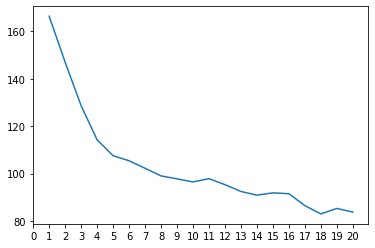

In [24]:
test(filename='ft06.txt',gen_size=20,pop_size=60,runs=5,tournament_size=5)

In [18]:
g

NameError: name 'g' is not defined